### Setup

In [1]:
SAMPLE   = "2016MagUp"
VRS_KAON = "v1.1.bc.tb"
VRS_PION = "v1.1.bc.tw"

chunk_size  = 8e6
reweighting = False

In [2]:
import os
import yaml
import pickle
import numpy as np
import tensorflow as tf

import matplotlib.font_manager
import matplotlib.pyplot as plt
import mplhep as hep

from lb_pidsim_train.trainers import DataHandler
from lb_pidsim_train.utils    import PidsimColTransformer

In [3]:
NP_FLOAT = np.float32
TF_FLOAT = tf.float32

### Configuration files

In [4]:
with open ("../training/config/config.yaml") as file:
  config = yaml.full_load (file)

with open ("../training/config/datasets.yaml") as file:
  datasets = yaml.full_load (file)

with open ("../training/config/variables.yaml") as file:
  variables = yaml.full_load (file)

with open ("../training/config/selections.yaml") as file:
  selections = yaml.full_load (file)

### Data loading

In [5]:
dh_k  = DataHandler()
dh_pi = DataHandler()

In [6]:
data_dir = config["data_dir"]

file_list_k  = datasets["GlobalPID"]["Kaon"][SAMPLE]
file_list_k  = [ f"{data_dir}/{file_name}" for file_name in file_list_k ]

file_list_pi = datasets["GlobalPID"]["Pion"][SAMPLE]
file_list_pi = [ f"{data_dir}/{file_name}" for file_name in file_list_pi ]

In [7]:
dh_k  . feed_from_root_files ( root_files = file_list_k , 
                               X_vars = variables["GlobalPID"]["X_vars"][SAMPLE] , 
                               Y_vars = variables["GlobalPID"]["Y_vars"][SAMPLE] , 
                               w_var  = variables["GlobalPID"]["w_vars"][SAMPLE] , 
                               selections = selections["GlobalPID"][SAMPLE] , 
                               tree_names = None , 
                               chunk_size = chunk_size , 
                               verbose = 1 )

dh_pi . feed_from_root_files ( root_files = file_list_pi , 
                               X_vars = variables["GlobalPID"]["X_vars"][SAMPLE] , 
                               Y_vars = variables["GlobalPID"]["Y_vars"][SAMPLE] , 
                               w_var  = variables["GlobalPID"]["w_vars"][SAMPLE] , 
                               selections = selections["GlobalPID"][SAMPLE] , 
                               tree_names = None , 
                               chunk_size = chunk_size , 
                               verbose = 1 )

Data-chunk of 7881769 rows correctly loaded in 16.844 s
Data-chunk of 7885217 rows correctly loaded in 13.848 s


In [8]:
dh_k  . prepare_dataset (verbose = 1)
dh_pi . prepare_dataset (verbose = 1)

Shuffle-time: 3.555 s
Shuffle-time: 3.185 s


### Preprocessing step

In [9]:
model_dir  = config["model_dir"]

model_name_k  = f"GlobalPID_Kaon_{SAMPLE}_{VRS_KAON}"
model_name_pi = f"GlobalPID_Pion_{SAMPLE}_{VRS_PION}"

In [10]:
scaler_X   = list()
scaler_Y   = list()
reweighter = list()

for model_name in [model_name_k, model_name_pi]:
  
  file_X = f"{model_dir}/{model_name}/transform_X.pkl"
  scaler_X . append ( PidsimColTransformer ( pickle.load ( open (file_X, "rb") ) ) )

  file_Y = f"{model_dir}/{model_name}/transform_Y.pkl"
  scaler_Y . append ( PidsimColTransformer ( pickle.load ( open (file_Y, "rb") ) ) )

  if reweighting:
    file_w = f"{model_dir}/{model_name}/saved_reweighter"
    reweighter . append ( tf.keras.models.load_model ( file_w ) )

### Generator output

In [11]:
gen_k  = tf.keras.models.load_model ( f"{model_dir}/{model_name_k}/saved_generator" )
gen_pi = tf.keras.models.load_model ( f"{model_dir}/{model_name_pi}/saved_generator" )

2022-04-08 00:05:27.258070: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-08 00:05:27.258279: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-08 00:05:27.258321: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (pclhcb06): /proc/driver/nvidia/version does not exist
2022-04-08 00:05:27.258688: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
Y_gen = list()
w_gen = list()

for i, dh, generator in zip ([0, 1], [dh_k, dh_pi], [gen_k, gen_pi]):

  batch_size = len(dh.X)
  latent_dim = generator.input_shape[1] - dh.X.shape[1]

  X_gen = scaler_X[i] . transform ( dh.X )
  X_gen = tf.convert_to_tensor ( X_gen, dtype = TF_FLOAT )
  latent_tensor = tf.random.normal ( shape = (batch_size, latent_dim), dtype = TF_FLOAT )
  input_tensor  = tf.concat ( [X_gen, latent_tensor], axis = 1 )

  gen_output = generator ( input_tensor ) . numpy() . astype (NP_FLOAT)
  Y_gen . append ( scaler_Y[i] . inverse_transform ( gen_output ) )

  if reweighting:
    w_gen . append ( reweighter[i] (X_gen) . numpy() . astype (NP_FLOAT) )
  else:
    w_gen . append ( np.copy(dh.w) . astype (NP_FLOAT) )

Y_gen_k, Y_gen_pi = Y_gen
w_gen_k, w_gen_pi = w_gen

2022-04-08 00:05:51.851137: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 4035465728 exceeds 10% of free system memory.
2022-04-08 00:05:52.304330: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 4035465728 exceeds 10% of free system memory.
2022-04-08 00:05:52.879503: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 4035465728 exceeds 10% of free system memory.
2022-04-08 00:05:53.433073: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 4035465728 exceeds 10% of free system memory.
2022-04-08 00:05:53.846324: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 4035465728 exceeds 10% of free system memory.


### Validation plots

In [13]:
plt.style.use(hep.style.LHCb2)
plt.rcParams["axes.linewidth"]    = 1.3
plt.rcParams["xtick.major.width"] = 1
plt.rcParams["ytick.major.width"] = 1
plt.rcParams["xtick.minor.width"] = 1
plt.rcParams["ytick.minor.width"] = 1
plt.rcParams["xtick.major.size"]  = 10
plt.rcParams["ytick.major.size"]  = 10
plt.rcParams["xtick.minor.size"]  = 5
plt.rcParams["ytick.minor.size"]  = 5

In [15]:
binning = np.linspace (-60, 60, 120)

h_ref_k , bins_ref_k = np.histogram ( dh_k.Y[:,1]  , bins = binning , weights = dh_k.w.flatten()  , density = True )
h_gen_k , bins_gen_k = np.histogram ( Y_gen_k[:,1] , bins = binning , weights = w_gen_k.flatten() , density = True )

h_ref_pi , bins_ref_pi = np.histogram ( dh_pi.Y[:,1]  , bins = binning , weights = dh_pi.w.flatten()  , density = True )
h_gen_pi , bins_gen_pi = np.histogram ( Y_gen_pi[:,1] , bins = binning , weights = w_gen_pi.flatten() , density = True )

y_min = 0
y_max = max ( max ( h_ref_k.max()  , h_gen_k.max()  ) ,
              max ( h_ref_pi.max() , h_gen_pi.max() ) )
y_max += 0.15 * y_max

In [16]:
img_dir  = "./images"
fig_name = f"PIDK_Kaon_vs_Pion_{SAMPLE}"

if not os.path.exists (img_dir): os.makedirs (img_dir)

<Figure size 700x900 with 0 Axes>

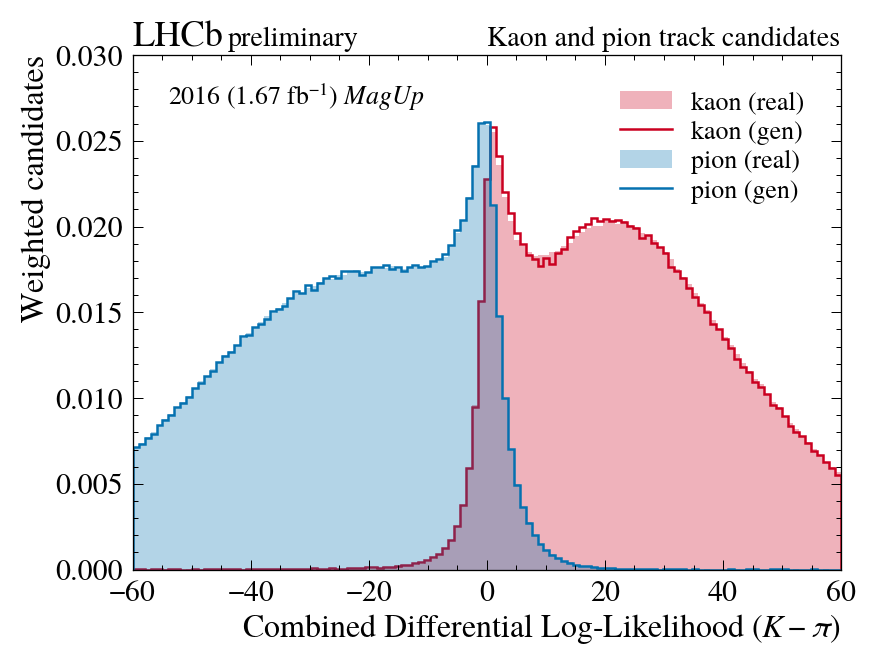

In [18]:
plt.figure (figsize = (7,9), dpi = 100)
fig, ax = plt.subplots()
ax.set_xlabel ( r"Combined Differential Log-Likelihood ($K-\pi$)", fontname = "serif", size = 32 )
ax.set_ylabel ( "Weighted candidates", fontname = "serif", size = 32 )

hep.histplot (h_ref_k, bins_ref_k, histtype = "fill", color = "#ca0020", alpha = 0.3, label = "kaon (real)")
hep.histplot (h_gen_k, bins_gen_k, histtype = "step", color = "#ca0020", lw = 2.5, label = "kaon (gen)")

hep.histplot (h_ref_pi, bins_ref_pi, histtype = "fill", color = "#0571b0", alpha = 0.3, label = "pion (real)")
hep.histplot (h_gen_pi, bins_gen_pi, histtype = "step", color = "#0571b0", lw = 2.5, label = "pion (gen)")

hep.lhcb.text("preliminary", loc = 0, fontname = "serif", fontsize = 28, italic = [False, False])
ax.annotate ( f"Kaon and pion track candidates", 
              ha = "right", va = "bottom",
              xy = (0.999,1.005), xycoords = "axes fraction",
              fontname = "serif", size = 28)
ax.annotate ( r"$2016~(1.67~\rm{fb}^{-1})~\it{MagUp}$", 
              ha = "left", va = "top",
              xy = (0.05, 0.95), xycoords = "axes fraction" ,
              fontname = "serif", size = 26 )

ax.legend ( loc = "upper right", prop = {"family" : "serif", "size" : 26} )
ax.set_xlim (binning[0], binning[-1])
ax.set_ylim (y_min, y_max)

plt.savefig (f"{img_dir}/{fig_name}.png")
plt.show()
plt.close()